<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tic-Toc-Toe-environment" data-toc-modified-id="Tic-Toc-Toe-environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tic Toc Toe environment</a></span><ul class="toc-item"><li><span><a href="#Initialization-and-attributes" data-toc-modified-id="Initialization-and-attributes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialization and attributes</a></span></li><li><span><a href="#Taking-actions" data-toc-modified-id="Taking-actions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Taking actions</a></span></li><li><span><a href="#Reward" data-toc-modified-id="Reward-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Reward</a></span></li></ul></li><li><span><a href="#Optimal-policy-for-Tic-Toc-Toe-environment" data-toc-modified-id="Optimal-policy-for-Tic-Toc-Toe-environment-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimal policy for Tic Toc Toe environment</a></span><ul class="toc-item"><li><span><a href="#An-example-of-optimal-player-playing-against-random-player" data-toc-modified-id="An-example-of-optimal-player-playing-against-random-player-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example of optimal player playing against random player</a></span></li><li><span><a href="#An-example-of-optimal-player-playing-against-optimal-player" data-toc-modified-id="An-example-of-optimal-player-playing-against-optimal-player-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>An example of optimal player playing against optimal player</a></span></li></ul></li><li><span><a href="#Performance-measures" data-toc-modified-id="Performance-measures-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance measures</a></span></li></ul></div>

In [1]:
# std
import os
import random
from typing import List, Dict

# imported
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

# customized
from tic_env import TictactoeEnv, OptimalPlayer

# set up for plt
SMALL_SIZE = 14
MEDIUM_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

# create folder to store plot
os.makedirs("plot",exist_ok = True)

# Performance measures

In [80]:
def run_one_game(agent1, agent2, env, switch: bool):
    grid, end, __  = env.observe()
    if switch:
        agent1.player, agent2.player = 'O', 'X'
    else:
        agent1.player, agent2.player = 'X', 'O'
    while end == False:
        if env.current_player == agent1.player:
            move = agent1.act(grid) 
            grid, end, winner = env.step(move, print_grid=False) 
        else:
            move = agent2.act(grid)
            grid, end, winner = env.step(move, print_grid=False) 
    return winner, agent1, agent2

In [89]:
def eval_metrics(agent1, agent2, n_episode: int = 500) -> Dict:
    env = TictactoeEnv()
    win, los, draw = 0, 0, 0
    res = []
        
    for episode in range(n_episode):
        env.reset()
        switch = i % 2
        winner, agent1, agent2 = run_one_game(agent1, agent2, env, switch)

        if winner == agent1.player:
            win += 1
            res.append(1)
        elif winner == agent2.player:
            los += 1
            res.append(-1)
        else:
            draw += 1
            res.append(0)
           
    return (win-los)/n_episode

# 2. Q Learning

In [4]:
from q_player import QPlayer

## 2.1 Learning from experts

In [96]:
from typing import Dict

def train_from_expert(
    player_qlearning: QPlayer,
    player_opt_for_train: OptimalPlayer,
    record_inter: int = 250,
    decrease_epsilon: bool = False,
    compute_metrics: bool = False,
) -> Dict:
    
    env = TictactoeEnv()
    reward_record = []
    avg_reward_record = {}
    if compute_metrics:
        player_opt = OptimalPlayer(epsilon=0)
        player_rand = OptimalPlayer(epsilon=1)
        metrics = {"M_opt": {}, "M_rand": {}}
    
    Turns_odd = np.array(["X", "O"])
    Turns_even = np.array(["O", "X"])

    for i in tqdm(range(20000)):
        env.reset()
        grid, end, winner = env.observe()
        if i % 2 == 0:
            Turns = Turns_odd
        else:
            Turns = Turns_even
        player_opt_for_train.player = Turns[0]
        player_qlearning.player = Turns[1]

        first_step = True
        while not end:
            if env.current_player == player_qlearning.player:
                if decrease_epsilon:
                    move = player_qlearning.act(grid, n=i+1)
                else:
                    move = player_qlearning.act(grid, n=0)
            else:
                move = player_opt_for_train.act(grid)

            grid, end, winner = env.step(move, print_grid=False)
            reward = env.reward(player_qlearning.player)
            
            # if next player is q_player, then optimal player finished his move, time to update Q_table
            # exception is the optimal player makes his first step
            if (env.current_player == player_qlearning.player or end) and not first_step:
                player_qlearning.update_q(
                    reward=reward,
                    grid=grid,
                    is_end=end,
                )

            first_step = False

        reward_record.append(env.reward(player=player_qlearning.player))

        if ((i + 1) % record_inter == 0) & (i != 0):
            avg_reward_record.update({i + 1: np.mean(reward_record)})
            reward_record = []
            
            if compute_metrics:
                player_qlearning.epsilon_min = 0
                player_qlearning.epsilon_max = 0
                metrics["M_opt"].update({i + 1: eval_metrics(player_qlearning, player_opt)})
                metrics["M_rand"].update({i + 1: eval_metrics(player_qlearning, player_rand)})
                player_qlearning.epsilon_min = 0.1
                player_qlearning.epsilon_max = 0.8
    if compute_metrics:        
        return avg_reward_record, metrics
    else:
        return avg_reward_record

In [77]:
random.seed(2022)

sample_number = 6
epsilon_list = []
for i in range(sample_number):
    epsilon_list.append(i/(sample_number-1))
    
avg_reward_epsilons = {}

for epsilon in epsilon_list:
    print("start training with epsilon = {}".format(epsilon))
    player_qlearning = QPlayer(player="X", epsilon_min=epsilon, epsilon_max=epsilon)
    player_opt_for_train = OptimalPlayer(epsilon=0.5)


    avg_reward_record = train_from_expert(player_qlearning, player_opt_for_train)
                    
    avg_reward_epsilons.update({epsilon: avg_reward_record})


start training with epsilon = 0.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:51<00:00, 387.07it/s]


start training with epsilon = 0.2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:53<00:00, 374.34it/s]


start training with epsilon = 0.4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:54<00:00, 369.97it/s]


start training with epsilon = 0.6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:53<00:00, 374.69it/s]


start training with epsilon = 0.8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:53<00:00, 370.67it/s]


start training with epsilon = 1.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:53<00:00, 371.00it/s]


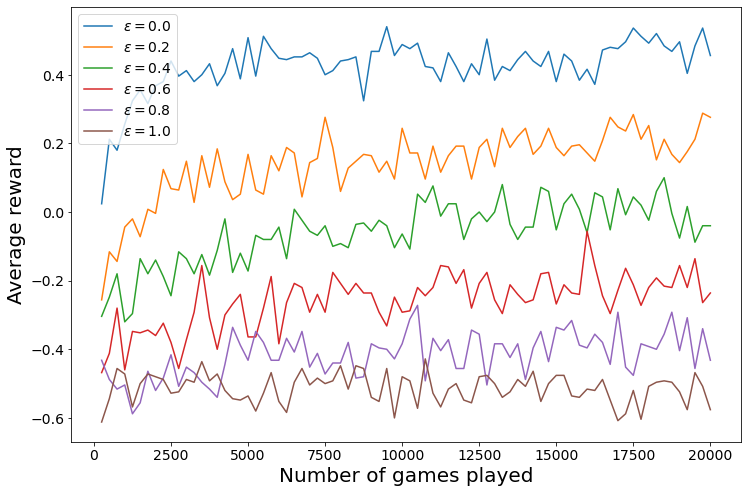

In [78]:
plt.figure(figsize=(12, 8))

for epsilon in epsilon_list:
    game_idx = list(avg_reward_epsilons[epsilon].keys())
    avg_rewards = list(avg_reward_epsilons[epsilon].values())
 
    plt.plot(game_idx,avg_rewards,label = "$\epsilon=$"+str(epsilon))
    
plt.legend()
plt.xlabel("Number of games played")
plt.ylabel("Average reward")

plt.savefig("plot/question1.pdf",dpi=300)
plt.show()


### 2.1.1 Decreasing exploration

In [91]:
random.seed(2022)

player_opt_for_train = OptimalPlayer(epsilon=0.5)

n_star_list = [1, 100, 1000, 10000, 20000, 40000]
avg_reward_record_dict = {}
metrics_dict = {"M_opt": {}, "M_rand": {}}
for n_star in n_star_list:
    print("start training with n^star = {}".format(n_star))
    player_qlearning = QPlayer(
        player="X", epsilon_min=0.1, epsilon_max=0.8, n_star=n_star
    )

    avg_reward_record, metrics = train_from_expert(
        player_qlearning, player_opt_for_train, decrease_epsilon=True, compute_metrics=True
    )

    avg_reward_record_dict.update({n_star: avg_reward_record})
    metrics_dict["M_opt"].update({n_star: metrics["M_opt"]})
    metrics_dict["M_rand"].update({n_star: metrics["M_rand"]})


start training with n^star = 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:23<00:00, 61.77it/s]


start training with n^star = 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:43<00:00, 58.24it/s]


start training with n^star = 1000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:51<00:00, 56.82it/s]


start training with n^star = 10000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:40<00:00, 58.74it/s]


start training with n^star = 20000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:39<00:00, 58.94it/s]


start training with n^star = 40000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:33<00:00, 59.94it/s]


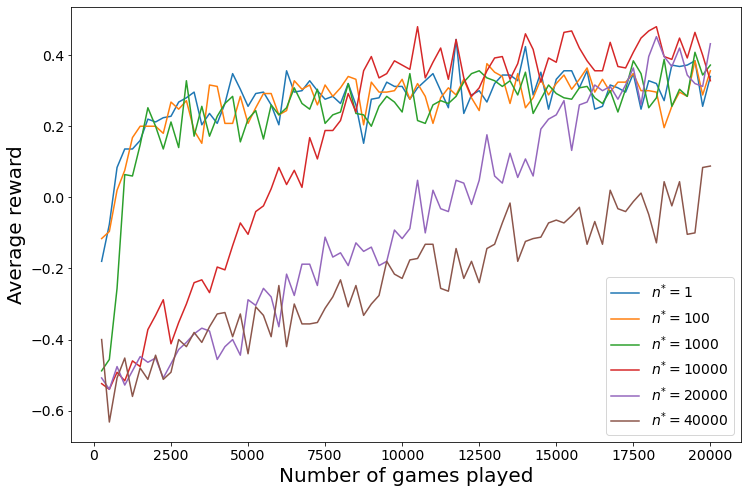

In [92]:
plt.figure(figsize=(12, 8))

for n_star in n_star_list:
    game_idx = list(avg_reward_record_dict[n_star].keys())
    avg_rewards = list(avg_reward_record_dict[n_star].values())
    plt.plot(game_idx,avg_rewards,label = "$n^{*}=$"+str(n_star))

plt.legend()
plt.xlabel("Number of games played")
plt.ylabel("Average reward")

plt.savefig("plot/question2.pdf",dpi=300)
plt.show()

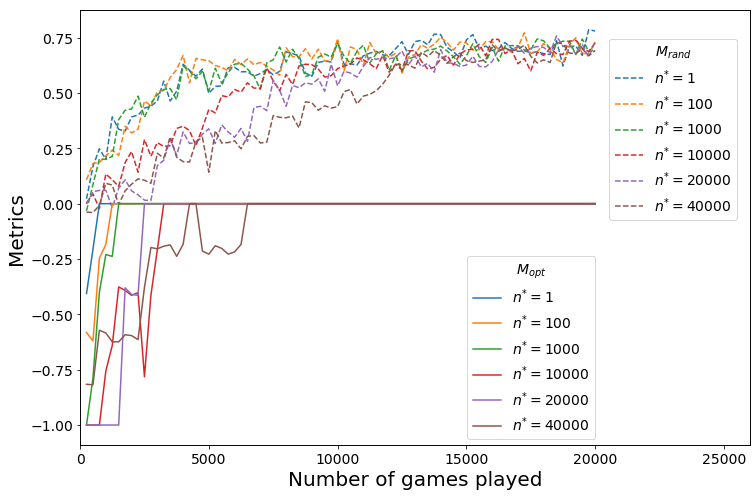

In [93]:
fig, ax = plt.subplots(figsize=(12, 8))

for n_star in n_star_list:
    game_idx = list(metrics_dict["M_rand"][n_star].keys())
    M_rand = list(metrics_dict["M_rand"][n_star].values())
    ax.plot(game_idx,M_rand,'--',label = "$n^{*}=$"+str(n_star))
ax.legend(title = '$M_{rand}$', bbox_to_anchor = (0.78, 0.95))

ax2 = ax.twiny()
for n_star in n_star_list:
    game_idx = list(metrics_dict["M_opt"][n_star].keys())
    M_opt = list(metrics_dict["M_opt"][n_star].values())
    ax2.plot(game_idx,M_opt,'-',label = "$n^{*}=$"+str(n_star))
ax2.legend(title = '$M_{opt}$', bbox_to_anchor = (0.78, 0.45))
ax2.get_xaxis().set_visible(False) 

ax.set_xlabel("Number of games played")
ax.set_xlim([0,26000])
ax2.set_xlim([0,26000])
ax.xaxis.set_ticks(np.arange(0,26000,5000))
ax.set_ylabel("Metrics")

plt.savefig("plot/question3.pdf",dpi=300)
plt.show()

### 2.1.2 Good experts and bad experts

In [97]:
random.seed(2022)

sample_number = 6
epsilon_expert_list = []
for i in range(sample_number):
    epsilon_expert_list.append(i/(sample_number-1))

best_n_star = 10000
    
avg_reward_record_dict = {}
metrics_dict = {"M_opt": {}, "M_rand": {}}
for epsilon_expert in epsilon_expert_list:
    print("start training with expert whose epsilton is {}".format(epsilon_expert))
    
    player_qlearning = QPlayer(
        player="X", epsilon_min=0.1, epsilon_max=0.8, n_star=best_n_star
    )
    player_opt_for_train = OptimalPlayer(epsilon=0.5)

    avg_reward_record, metrics = train_from_expert(
        player_qlearning, player_opt_for_train, decrease_epsilon=True, compute_metrics=True
    )

    avg_reward_record_dict.update({epsilon_expert: avg_reward_record})
    metrics_dict["M_opt"].update({epsilon_expert: metrics["M_opt"]})
    metrics_dict["M_rand"].update({epsilon_expert: metrics["M_rand"]})
    
    if epsilon_expert == 0.0:
        Q_table1 = player_qlearning.q_table
    elif epsilon_expert == 1.0:
        Q_table2 = player_qlearning.q_table

start training with expert whose epsilton is 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:43<00:00, 58.17it/s]


start training with expert whose epsilton is 0.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:38<00:00, 59.14it/s]


start training with expert whose epsilton is 0.4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:47<00:00, 57.56it/s]


start training with expert whose epsilton is 0.6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:35<00:00, 59.70it/s]


start training with expert whose epsilton is 0.8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:42<00:00, 58.47it/s]


start training with expert whose epsilton is 1.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:55<00:00, 56.31it/s]


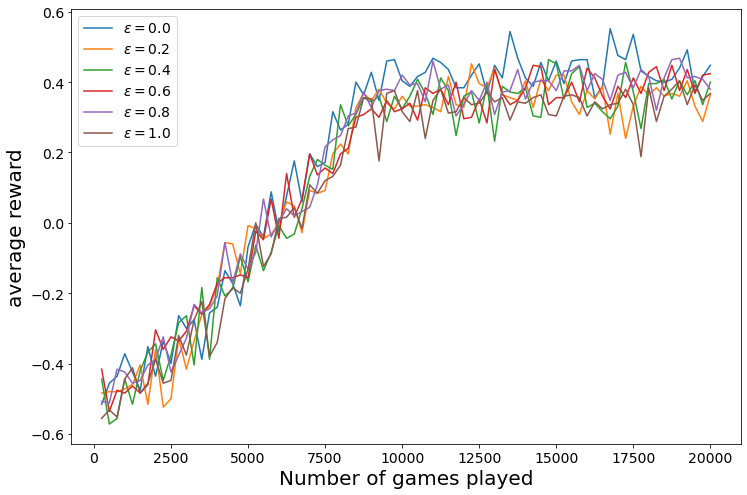

In [98]:
plt.figure(figsize=(12, 8))

for epsilon_expert in epsilon_expert_list:
    game_idx = list(avg_reward_record_dict[epsilon_expert].keys())
    avg_rewards = list(avg_reward_record_dict[epsilon_expert].values())
    plt.plot(game_idx,avg_rewards,label = "$\epsilon=$"+str(epsilon_expert))

plt.legend()
plt.xlabel("Number of games played")
plt.ylabel("average reward")

plt.show()

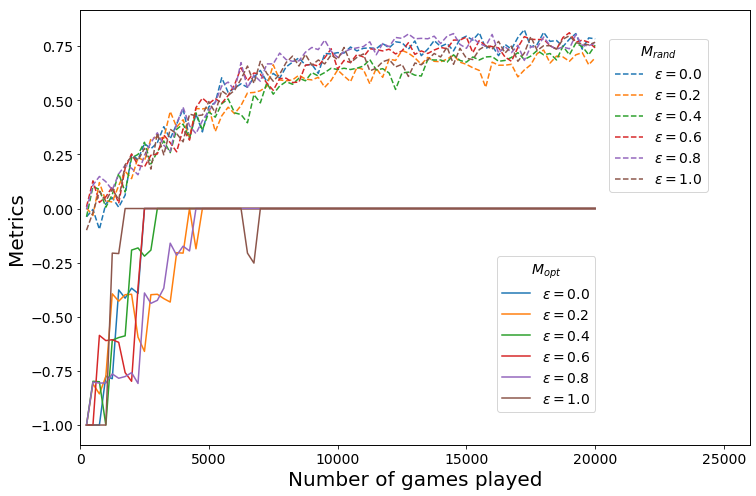

In [99]:
fig, ax = plt.subplots(figsize=(12, 8))

for epsilon_expert in epsilon_expert_list:
    game_idx = list(metrics_dict["M_rand"][epsilon_expert].keys())
    M_rand = list(metrics_dict["M_rand"][epsilon_expert].values())
    ax.plot(game_idx,M_rand,'--',label = "$\epsilon=$"+str(epsilon_expert))
ax.legend(title = '$M_{rand}$', bbox_to_anchor = (0.78, 0.95))

ax2 = ax.twiny()
for epsilon_expert in epsilon_expert_list:
    game_idx = list(metrics_dict["M_opt"][epsilon_expert].keys())
    M_opt = list(metrics_dict["M_opt"][epsilon_expert].values())
    ax2.plot(game_idx,M_opt,'-',label = "$\epsilon=$"+str(epsilon_expert))
ax2.legend(title = '$M_{opt}$', bbox_to_anchor = (0.78, 0.45))
ax2.get_xaxis().set_visible(False) 

ax.set_xlabel("Number of games played")
ax.set_xlim([0,26000])
ax2.set_xlim([0,26000])
ax.xaxis.set_ticks(np.arange(0,26000,5000))
ax.set_ylabel("Metrics")

plt.savefig("plot/question4.pdf",dpi=300)
plt.show()

In [100]:
# question5
max_metric = {"opt": -1, "rand": -1}
for epsilon_expert in epsilon_expert_list:
    if max_metric["opt"] < metrics_dict["M_opt"][epsilon_expert][20000]:
        max_metric["opt"] = metrics_dict["M_opt"][epsilon_expert][20000]
        
    if max_metric["rand"] < metrics_dict["M_rand"][epsilon_expert][20000]:
        max_metric["rand"] = metrics_dict["M_rand"][epsilon_expert][20000]
        max_rand_epsilon = epsilon_expert
print("Highest M_opt is: {}".format(max_metric["opt"]))
print("Highest M-rand is: {}. Corresponding epsilon is: {}".format(max_metric["rand"],max_rand_epsilon))

Highest M_opt is: 0.0
Highest M-rand is: 0.784. Corresponding epsilon is: 0.0


In [101]:
# question 6
def print_q_table(state: "Tuple[int]", Q_table1: dict, Q_table2: dict):
    print("*****Q_table for the following grid is:******")
    value2player = {0: '-', 1: 'X', -1: 'O'}
    grid = np.array(state).reshape(3,3)
    for i in range(3):
        print('|', end='')
        for j in range(3):
            print(value2player[int(grid[i,j])], end=' ' if j<2 else '')
        print('|')
    print()
    print("Q1: ")
    print(Q_table1[state])
    print("Q2: ")
    print(Q_table2[state])
    
print_q_table((0,0,0,0,0,0,0,0,0), Q_table1, Q_table2)
print_q_table((0,0,0,0,1,0,-1,0,1), Q_table1, Q_table2)
print_q_table((0, 0, 1, -1, 1, 0, 0, 0, 0), Q_table1, Q_table2)

*****Q_table for the following grid is:******
|- - -|
|- - -|
|- - -|

Q1: 
{0: 0.04266962306146702, 1: 0.042916461813817704, 2: 0.020399786544273886, 3: 0.052889800380485484, 4: 0.008159256222550319, 5: 0.04161703684484163, 6: 0.7337906953357678, 7: 0.11604302271179802, 8: 0.10847052509426246}
Q2: 
{0: 0.04961377588487864, 1: 0.014960113347497389, 2: 0.13526183003803674, 3: 0.003962808371483504, 4: 0.005898998933000972, 5: 0.6140518056825439, 6: 0.024999027685011048, 7: 0.07389577485797696, 8: 0.06885502103372043}
*****Q_table for the following grid is:******
|- - -|
|- X -|
|O - X|

Q1: 
{0: 0.08628221519599392, 1: -0.1833503125, 2: -0.0475, 3: -0.142625, 5: -0.2262190625, 7: -0.2262190625}
Q2: 
{0: 0.1075854277122747, 1: -0.0975, 2: -0.0475, 3: -0.08850159703125, 5: -0.05, 7: -0.05}
*****Q_table for the following grid is:******
|- - X|
|O X -|
|- - -|

Q1: 
{0: -0.0907253125, 1: -0.095125, 5: -0.18109406249999999, 6: -0.06191791442755535, 7: -0.092625, 8: -0.1310940625}
Q2: 
{0: -0.

## 2.2 Learning by self-practice

In [102]:
def train_by_self(
    player_qlearning1: QPlayer,
    player_qlearning2: QPlayer,
    record_inter: int = 250,
    decrease_epsilon: bool = False,
) -> Dict:
    
    env = TictactoeEnv()
    
    player_opt = OptimalPlayer(epsilon=0)
    player_rand = OptimalPlayer(epsilon=1)
    player_qlearning1.player = "X"
    player_qlearning2.player = "O"
    player_qlearning_eval = QPlayer(player="X", epsilon_min=0, epsilon_max=0)
    
    # make sure they use the same q_table
    player_qlearning2.q_table = player_qlearning1.q_table
    player_qlearning_eval.q_table = player_qlearning1.q_table
    
    metrics = {"M_opt": {}, "M_rand": {}}
    
    for i in tqdm(range(20000)):
        env.reset()
        grid, end, winner = env.observe()
        
        first_step = True
        while not end:
            if env.current_player == player_qlearning1.player:
                if decrease_epsilon:
                    move = player_qlearning1.act(grid, n=i+1)
                else:
                    move = player_qlearning1.act(grid)
            elif env.current_player == player_qlearning2.player:
                if decrease_epsilon:
                    move = player_qlearning2.act(grid, n=i+1)
                else:
                    move = player_qlearning2.act(grid)
            else:
                raise Exception("none of the player is match!")

            grid, end, winner = env.step(move, print_grid=False)
            reward1 = env.reward(player_qlearning1.player)
            reward2 = env.reward(player_qlearning2.player)

            if first_step:
                first_step = False
                continue
            elif env.current_player == player_qlearning1.player:
                player_qlearning1.update_q(reward=reward1, grid=grid, is_end=end)
                if end:
                    player_qlearning2.update_q(reward=reward2,grid=grid,is_end=end)
            else:
                player_qlearning2.update_q(reward=reward2,grid=grid,is_end=end)
                if end:
                    player_qlearning1.update_q(reward=reward1, grid=grid, is_end=end)

        if ((i + 1) % record_inter == 0) & (i != 0):
            metrics["M_opt"].update({i + 1: eval_metrics(player_qlearning_eval, player_opt)})
            metrics["M_rand"].update({i + 1: eval_metrics(player_qlearning_eval, player_rand)})
            
    return metrics

### learning with fixed epsilon

In [ ]:
random.seed(2022)

sample_number = 6
epsilon_list = []
for i in range(sample_number):
    epsilon_list.append(i / (sample_number - 1))

metrics_dict = {"M_opt": {}, "M_rand": {}}
for epsilon in epsilon_list:
    print("start training with epsilton = {}".format(epsilon))
    player_qlearning1 = QPlayer(player="X", epsilon_min=epsilon, epsilon_max=epsilon)
    player_qlearning2 = QPlayer(player="O", epsilon_min=epsilon, epsilon_max=epsilon)
    
    metrics = train_by_self(player_qlearning1, player_qlearning2)

    metrics_dict["M_opt"].update({epsilon: metrics["M_opt"]})
    metrics_dict["M_rand"].update({epsilon: metrics["M_rand"]})


start training with epsilton = 0.0


 12%|████████████████████                                                                                                                                             | 2495/20000 [00:28<02:08, 136.05it/s]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

for epsilon in epsilon_list:
    game_idx = list(metrics_dict["M_rand"][epsilon].keys())
    M_rand = list(metrics_dict["M_rand"][epsilon].values())
    ax.plot(game_idx,M_rand,'--',label = "$\epsilon=$"+str(epsilon))
ax.legend(title = '$M_{rand}$', bbox_to_anchor = (0.78, 0.95))

ax2 = ax.twiny()
for epsilon in epsilon_list:
    game_idx = list(metrics_dict["M_opt"][epsilon].keys())
    M_opt = list(metrics_dict["M_opt"][epsilon].values())
    ax2.plot(game_idx,M_opt,'-',label = "$\epsilon=$"+str(epsilon))
ax2.legend(title = '$M_{opt}$', bbox_to_anchor = (0.78, 0.45))
ax2.get_xaxis().set_visible(False) 

ax.set_xlabel("Number of games played")
ax.set_xlim([0,26000])
ax2.set_xlim([0,26000])
ax.xaxis.set_ticks(np.arange(0,26000,5000))
ax.set_ylabel("Metrics")

plt.savefig("plot/question7.pdf",dpi=300)
plt.show()

### Learning with decreasing exploration

In [ ]:
random.seed(2022)

n_star_list = [1, 100, 1000, 10000, 20000, 40000]

metrics_dict = {"M_opt": {}, "M_rand": {}}
for n_star in n_star_list:
    print("start training with n_star = {}".format(n_star))
    player_qlearning1 = QPlayer(player="X", epsilon_min=0.1, epsilon_max=0.8, n_star=n_star)
    player_qlearning2 = QPlayer(player="O", epsilon_min=0.1, epsilon_max=0.8, n_star=n_star)

    metrics = train_by_self(player_qlearning1, player_qlearning2, decrease_epsilon=True)
    
    metrics_dict["M_opt"].update({n_star: metrics["M_opt"]})
    metrics_dict["M_rand"].update({n_star: metrics["M_rand"]})


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

for n_star in n_star_list:
    game_idx = list(metrics_dict["M_rand"][n_star].keys())
    M_rand = list(metrics_dict["M_rand"][n_star].values())
    ax.plot(game_idx,M_rand,'--',label = "$n^{*}=$"+str(n_star))
ax.legend(title = '$M_{rand}$', bbox_to_anchor = (0.78, 0.95))

ax2 = ax.twiny()
for n_star in n_star_list:
    game_idx = list(metrics_dict["M_opt"][n_star].keys())
    M_opt = list(metrics_dict["M_opt"][n_star].values())
    ax2.plot(game_idx,M_opt,'-',label = "$n^{*}=$"+str(n_star))
ax2.legend(title = '$M_{opt}$', bbox_to_anchor = (0.78, 0.45))
ax2.get_xaxis().set_visible(False) 

ax.set_xlabel("Number of games played")
ax.set_xlim([0,26000])
ax2.set_xlim([0,26000])
ax.xaxis.set_ticks(np.arange(0,26000,5000))
ax.set_ylabel("Metrics")

plt.savefig("plot/question8.pdf",dpi=300)
plt.show()

In [ ]:
# question 9
max_metric = {"opt": -1, "rand": -1}
for n_star in n_star_list:
    if max_metric["opt"] < metrics_dict["M_opt"][n_star][20000]:
        max_metric["opt"] = metrics_dict["M_opt"][n_star][20000]
        max_n_star_opt = n_star
        
    if max_metric["rand"] < metrics_dict["M_rand"][n_star][20000]:
        max_metric["rand"] = metrics_dict["M_rand"][n_star][20000]
        max_n_star_rand = n_star
        
print("Highest M_opt is: {}. Corresponding n_star is: {}".format(max_metric["opt"],max_n_star_opt))
print("Highest M-rand is: {}. Corresponding n_star is: {}".format(max_metric["rand"],max_n_star_rand))

In [ ]:
# question 10
# Visualize Q-values

def print_q_table(state: "Tuple[int]", Q_table1: dict, Q_table2: dict):
    print("*****Q_table for the following grid is:******")
    value2player = {0: '-', 1: 'X', -1: 'O'}
    grid = np.array(state).reshape(3,3)
    for i in range(3):
        print('|', end='')
        for j in range(3):
            print(value2player[int(grid[i,j])], end=' ' if j<2 else '')
        print('|')
    print()
    print("Q1: ")
    print(Q_table1[state])
    print("Q2: ")
    print(Q_table2[state])
    
state1 = (0,0,0,0,0,0,0,0,0)
state2 = (1,1,0,-1,-1,0,0,0,0)
state3 = (1,1,0,-1,0,0,0,0,0)
states = [state1, state2, state3]


fig, axes = plt.subplots(1,3,figsize=(20, 8))

value2player = {0: ' -', 1: 'X', -1: 'O'}

for idx,state in enumerate(states):
    q_table = np.zeros((3,3))
    for action in list(player_qlearning_eval.q_table[state].keys()):
        q_table[action//3, action%3] = player_qlearning_eval.q_table[state][action]
    
    im = axes[idx].imshow(q_table)
    axes[idx].get_xaxis().set_visible(False)
    axes[idx].get_yaxis().set_visible(False)
    state_symbol = []
    for value in list(state):
        state_symbol.append(value2player[value])
    axes[idx].set_title('|{0} {1} {2}|\n|{3} {4} {5}|\n|{6} {7} {8}|'.format(*state_symbol), fontsize = 40)
    
    for i in range(3):
        for j in range(3):
            text = axes[idx].text(j, i, round(q_table[i, j],3),
                           ha="center", va="center", color="w", fontsize=20)

plt.savefig("plot/question10.pdf",dpi=300)
plt.show()